## Project Overview

This study adopts a comparative approach to detect stress in Reddit posts using both contextual and psychologically informed features.

First, textual embeddings are generated using BERT, developed by Google. A random forest classifier is trained on these embeddings to perform binary classification ("Stressed" vs "Non-stressed").

Second, linguistic features from Linguistic Inquiry and Word Count (LIWC) are used to train a separate random forest model, providing theory-driven psychological signals.

Third, BERT and LIWC features are concatenated to train a combined Random Forest model. This allows comparison between contextual, psychologically grounded, and hybrid representations.

Model performance is evaluated using F1-score on the predefined test set.

## Imports

In [16]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np
import os
import pandas as pd
import pickle
import torch
import seaborn as sns
import shap
from sklearn.base import ClassifierMixin
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_score, recall_score
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from transformers import AutoTokenizer, AutoModelForTextEncoding


## Set Seed

In [17]:
SEED = 42

## Load Data

In [18]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [19]:
DEVICE

device(type='cpu')

In [20]:
DATA_PATH = os.path.normpath(os.path.join("..", "data"))
train_df = pd.read_csv(os.path.join(DATA_PATH, "dreaddit-train.csv"))
test_df = pd.read_csv(os.path.join(DATA_PATH, "dreaddit-test.csv"))

In [21]:
train_df.head()

,subreddit,post_id,sentence_range,text,id,label,confidence,social_timestamp,social_karma,syntax_ari,...,lex_dal_min_pleasantness,lex_dal_min_activation,lex_dal_min_imagery,lex_dal_avg_activation,lex_dal_avg_imagery,lex_dal_avg_pleasantness,social_upvote_ratio,social_num_comments,syntax_fk_grade,sentiment
0,ptsd,8601tu,"(15, 20)","He said he had not felt that way before, sugge...",33181,1,0.8,1521614353,5,1.806818,...,1.000,1.1250,1.0,1.77000,1.52211,1.89556,0.86,1,3.253573,-0.002742
1,assistance,8lbrx9,"(0, 5)","Hey there r/assistance, Not sure if this is th...",2606,0,1.0,1527009817,4,9.429737,...,1.125,1.0000,1.0,1.69586,1.62045,1.88919,0.65,2,8.828316,0.292857
2,ptsd,9ch1zh,"(15, 20)",My mom then hit me with the newspaper and it s...,38816,1,0.8,1535935605,2,7.769821,...,1.000,1.1429,1.0,1.83088,1.58108,1.85828,0.67,0,7.841667,0.011894
3,relationships,7rorpp,"[5, 10]","until i met my new boyfriend, he is amazing, h...",239,1,0.6,1516429555,0,2.667798,...,1.000,1.1250,1.0,1.75356,1.52114,1.98848,0.50,5,4.104027,0.141671
4,survivorsofabuse,9p2gbc,"[0, 5]",October is Domestic Violence Awareness Month a...,1421,1,0.8,1539809005,24,7.554238,...,1.000,1.1250,1.0,1.77644,1.64872,1.81456,1.00,1,7.910952,-0.204167


In [22]:
test_df.head()

,id,subreddit,post_id,sentence_range,text,label,confidence,social_timestamp,social_karma,syntax_ari,...,lex_dal_min_pleasantness,lex_dal_min_activation,lex_dal_min_imagery,lex_dal_avg_activation,lex_dal_avg_imagery,lex_dal_avg_pleasantness,social_upvote_ratio,social_num_comments,syntax_fk_grade,sentiment
0,896,relationships,7nu7as,"[50, 55]","Its like that, if you want or not.“ ME: I have...",0,0.8,1.514981e+09,22,-1.238793,...,1.0000,1.2000,1.0,1.65864,1.32245,1.80264,0.63,62,-0.148707,0.000000
1,19059,anxiety,680i6d,"(5, 10)",I man the front desk and my title is HR Custom...,0,1.0,1.493348e+09,5,7.684583,...,1.4000,1.1250,1.0,1.69133,1.69180,1.97249,1.00,2,7.398222,-0.065909
2,7977,ptsd,8eeu1t,"(5, 10)",We'd be saving so much money with this new hou...,1,1.0,1.524517e+09,10,2.360408,...,1.1429,1.0000,1.0,1.70974,1.52985,1.86108,1.00,8,3.149288,-0.036818
3,1214,ptsd,8d28vu,"[2, 7]","My ex used to shoot back with ""Do you want me ...",1,0.5,1.524018e+09,5,5.997000,...,1.0000,1.3000,1.0,1.72615,1.52000,1.84909,1.00,7,6.606000,-0.066667
4,1965,relationships,7r1e85,"[23, 28]",I haven’t said anything to him yet because I’m...,0,0.8,1.516200e+09,138,4.649418,...,1.1250,1.1429,1.0,1.75642,1.43582,1.91725,0.84,70,4.801869,0.141667


## Check for NaN Values

In [23]:
train_df[train_df.isna().any(axis=1)]

,subreddit,post_id,sentence_range,text,id,label,confidence,social_timestamp,social_karma,syntax_ari,...,lex_dal_min_pleasantness,lex_dal_min_activation,lex_dal_min_imagery,lex_dal_avg_activation,lex_dal_avg_imagery,lex_dal_avg_pleasantness,social_upvote_ratio,social_num_comments,syntax_fk_grade,sentiment


In [24]:
test_df[test_df.isna().any(axis=1)]

,id,subreddit,post_id,sentence_range,text,label,confidence,social_timestamp,social_karma,syntax_ari,...,lex_dal_min_pleasantness,lex_dal_min_activation,lex_dal_min_imagery,lex_dal_avg_activation,lex_dal_avg_imagery,lex_dal_avg_pleasantness,social_upvote_ratio,social_num_comments,syntax_fk_grade,sentiment


The check shows that there is no missing data in the Dreaddit dataset provided.

## Exploratory Data Analysis

We conduct preliminary exploratory data analysis (EDA) to understand the structure and distribution of the Dreaddit dataset.

First and foremost, we examine the composition of labels ("Stressed" vs "Non-stressed") for both the training and testing sets, so as to assess class balance and ensure consistency across splits.

Moreover, label proportions are analysed by subreddit, using grouped bar charts. This allows us to inspect potential differences in the expression of stress across communities, whilst identifying subreddits that may present greater classification difficulty.

Furthermore, the distribution of text length is visualised using histograms for both datasets.

Finally, tone and sentiment scores are plotted alongside stress labels, with the use of scatter plots. This provides an initial view of whether affective signals meaningfully differentiate stressed from non-stressed posts.

In [25]:
PLOTS_FOLDER_PATH = os.path.normpath(os.path.join(os.getcwd(), "..", "plots"))
os.makedirs(PLOTS_FOLDER_PATH, exist_ok=True)

EDA_FOLDER_PATH = os.path.normpath(os.path.join(PLOTS_FOLDER_PATH, "eda"))
os.makedirs(EDA_FOLDER_PATH, exist_ok=True)

### Stress Label Counts

In [26]:
def get_label_counts(df):
    return df["label"].value_counts(normalize=True)

In [27]:
get_label_counts(train_df)

label
1    0.524313
0    0.475687
Name: proportion, dtype: float64

In [28]:
get_label_counts(test_df)

label
1    0.516084
0    0.483916
Name: proportion, dtype: float64

Upon determining the class composition of the training and testing set, we see that there are little imbalances in the data. Hence, strategies like oversampling and undersampling need not be implemented.

### Stress Label Counts by Subreddits

In [29]:
def plot_label_counts_by_subreddit(df, df_name):
    fig, ax = plt.subplots(figsize=(10, 6))

    # grouped bar chart
    sns.countplot(
        data=df,
        x="subreddit",
        hue="label",
        order=df["subreddit"].value_counts().index
    )

    # set title, axes and legend
    plt.title(f"Stress Label Counts by Subreddit in {df_name}")
    ax.set_xlabel("Subreddit")
    ax.set_ylabel("Count")
    ax.legend(title="Label")

    # edit x axis
    plt.xticks(rotation=45)

    plt.tight_layout()

    # save plot
    plt.savefig(os.path.join(EDA_FOLDER_PATH, f"label_counts_by_subreddit_{df_name.lower()}.png"))

    plt.show()

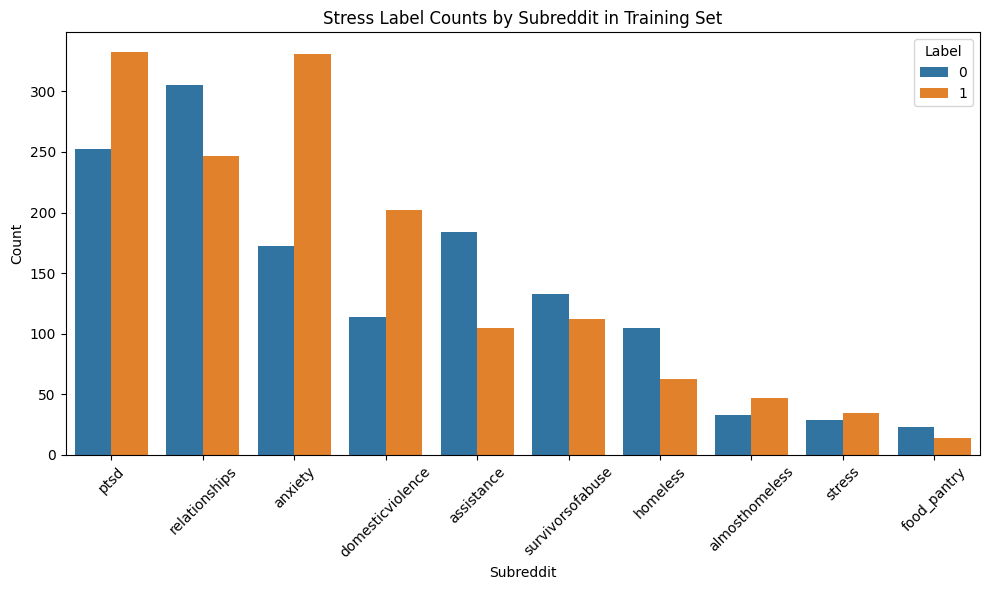

In [30]:
plot_label_counts_by_subreddit(train_df, "Training Set")

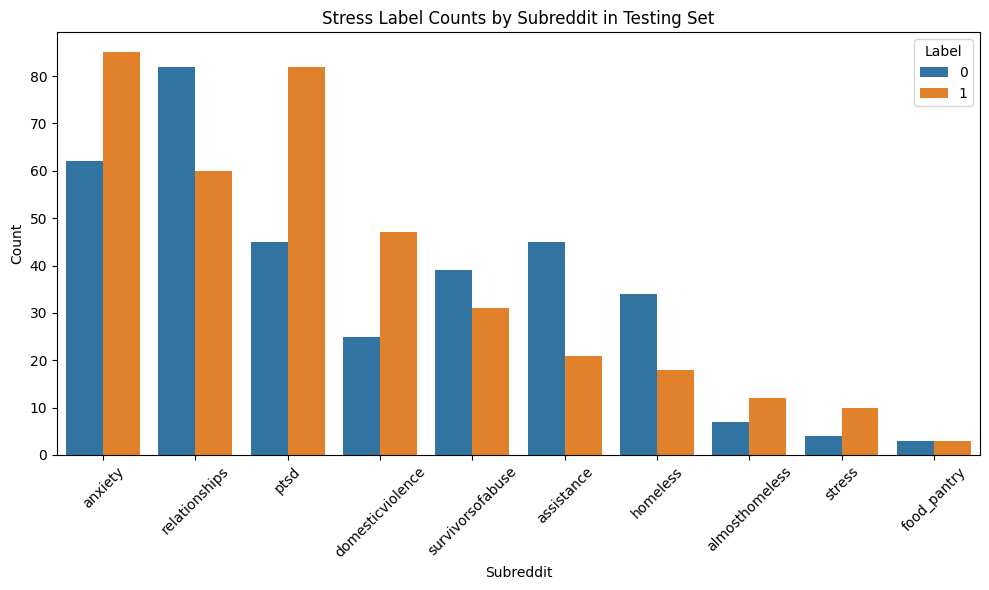

In [31]:
plot_label_counts_by_subreddit(test_df, "Testing Set")

The grouped bar charts show clear variation in stress prevalence across subreddits.

Subreddits such as r/ptsd, r/anxiety, and r/domesticviolence contain substantially higher proportions of "1" (stressed) labels. This is expected, as these communities centre on psychological distress and trauma-related experiences. In particular, r/anxiety and r/ptsd function as support forums where users can seek help, share symptoms, and describe ongoing emotional struggles. Similarly, r/domesticviolence may contain disclosures of abuse and crisis situations, which can be associated with stress signals in language.

Contrastingly, r/relationships and r/assistance show higher proportions of "0" (non-stressed) labels. While r/relationships includes discussions of interpersonal issues, many posts are advisory or reflective rather than acute expressions of distress. For r/assistance, a notable portion of texts consists of practical guidance, informational exchanges, or motivational and self-help messages, which may dilute explicit markers of stress.

In sum, these patterns suggest that stress expression is shaped not only by individual psychology, but also by community norms and posting intent - this highlights the influence of subreddit context on classification difficulty.

### Text Length

In [32]:
def plot_text_length(df, df_name):
    fig, ax = plt.subplots(figsize=(10, 6))

    # histogram
    sns.histplot(df["lex_liwc_WC"], bins=40, kde=True)

    # set title and axes
    plt.title(f"Distribution of Word Count in {df_name}")
    ax.set_xlabel("Number of Words")
    ax.set_ylabel("Frequency")
    
    plt.tight_layout()

    # save plot
    plt.savefig(os.path.join(EDA_FOLDER_PATH, f"text_length_distribution_{df_name.lower()}.png"))
                
    plt.show()

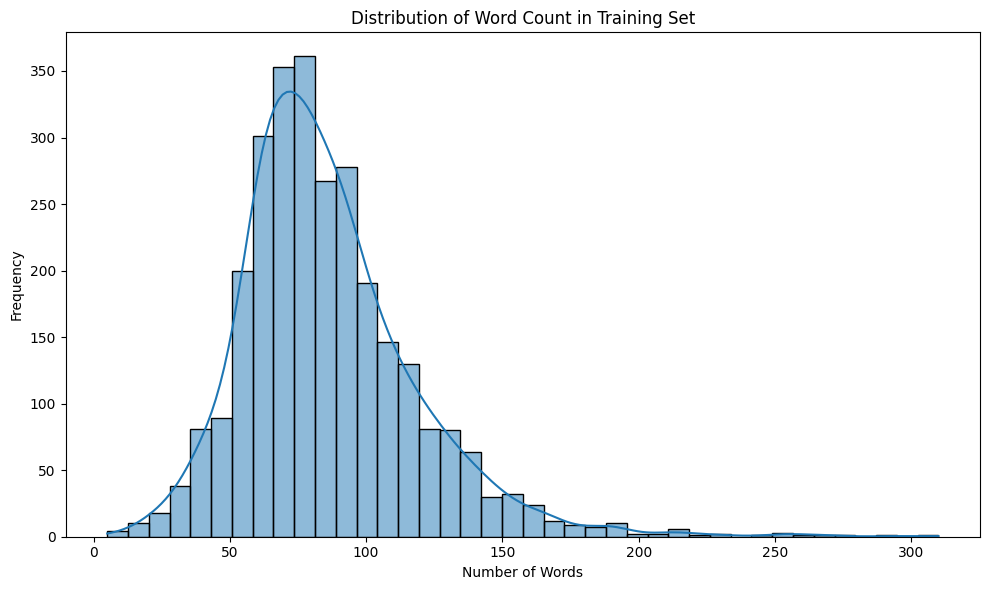

In [33]:
plot_text_length(train_df, "Training Set")

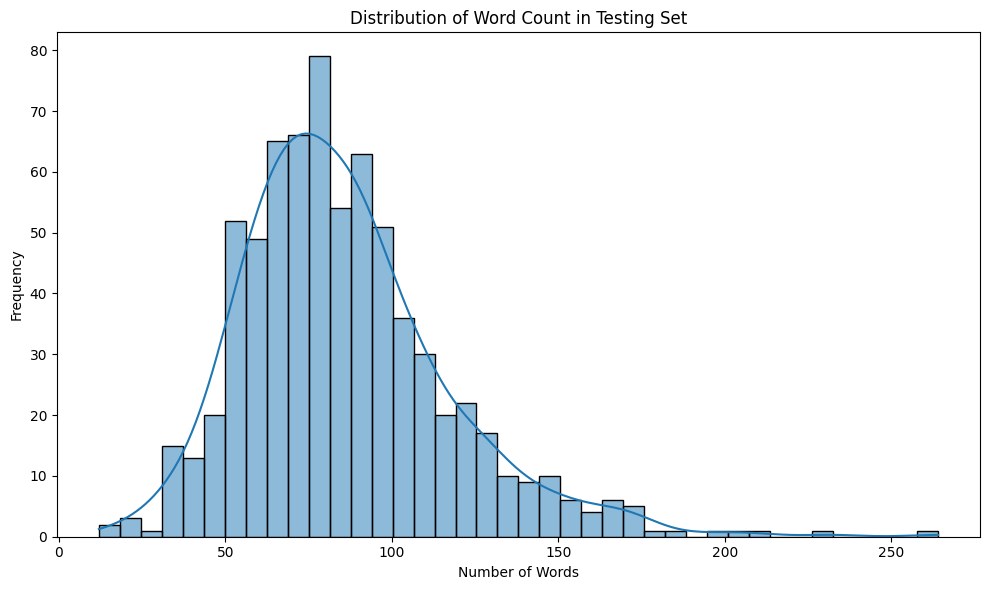

In [34]:
plot_text_length(test_df, "Testing Set")

We see that for both training and testing sets, the majority of the texts are 70-80 words long.

In [35]:
def find_short_texts(df, min_text_length):
    df = df.copy(deep=True)
    df["text_length"] = df["text"].apply(lambda x: len(x.split()))
    df_short_texts = df[df["text_length"] < min_text_length]
    return df_short_texts.drop(["text_length"], axis=1)

In [36]:
MIN_TEXT_LENGTH = 5       # In terms of approximate number of words (separated by spaces)

In [37]:
find_short_texts(df=train_df, min_text_length=MIN_TEXT_LENGTH)

,subreddit,post_id,sentence_range,text,id,label,confidence,social_timestamp,social_karma,syntax_ari,...,lex_dal_min_pleasantness,lex_dal_min_activation,lex_dal_min_imagery,lex_dal_avg_activation,lex_dal_avg_imagery,lex_dal_avg_pleasantness,social_upvote_ratio,social_num_comments,syntax_fk_grade,sentiment
295,domesticviolence,7idwpv,"(10, 15)",#NAME?,31315,0,0.800000,1512724877,10,1.913846,...,1.2857,1.3333,1.0,1.75970,1.46364,1.96712,0.92,9,1.975077,0.343750
1592,anxiety,7ti69n,"[15, 20]",#NAME?,469,1,0.571429,1517114200,3,9.900000,...,1.0000,1.5000,1.0,1.82062,1.85000,1.77778,1.00,7,3.935556,-0.066667
2190,ptsd,9ut4zv,"[30, 35]",#NAME?,559,1,1.000000,1541543111,9,11.497297,...,1.1429,1.1429,1.0,1.80001,1.75833,1.85932,0.85,9,9.484459,-0.400000
2563,domesticviolence,8m1irj,"(15, 20)",#NAME?,29201,0,0.800000,1527252930,23,6.356558,...,1.0000,1.1250,1.0,1.66671,1.56279,1.95929,1.00,4,6.422609,0.220833


In [38]:
find_short_texts(df=test_df, min_text_length=MIN_TEXT_LENGTH)

,id,subreddit,post_id,sentence_range,text,label,confidence,social_timestamp,social_karma,syntax_ari,...,lex_dal_min_pleasantness,lex_dal_min_activation,lex_dal_min_imagery,lex_dal_avg_activation,lex_dal_avg_imagery,lex_dal_avg_pleasantness,social_upvote_ratio,social_num_comments,syntax_fk_grade,sentiment


As we can see, there are a few texts that are abnormally short. There is a need to remove them, as these texts do not have enough information for us to make a prediction on whether they correspond to stress.

### Readability and Sentiment, By Stress Label

In [39]:
def plot_tone_against_sentiment_by_label(df, df_name):
    fig, ax = plt.subplots(figsize=(10, 6))

    # scatter plot by label
    sns.scatterplot(
        data=df,
        x="sentiment",
        y="lex_liwc_Tone",
        hue="label",
        palette={0: "#4C72B0", 1: "#DD8452"}
    )

    # set title, axes and legend
    plt.title(f"Tone and Sentiment of Text, By Stress Label ({df_name})")
    ax.set_xlabel("Sentiment Score")
    ax.set_ylabel("LIWC Tone")
    ax.legend(title="Label")

    # edit x axis
    ax.set_xlim(-1, 1)
    ax.xaxis.set_major_locator(mticker.MultipleLocator(0.2))
    
    # edit y axis
    ax.set_ylim(0, 100)
    ax.yaxis.set_major_locator(mticker.MultipleLocator(10))
    
    plt.tight_layout()

    # save plot
    plt.savefig(os.path.join(EDA_FOLDER_PATH, f"tone_sentiment_by_label_{df_name.lower()}.png"))

    plt.show()

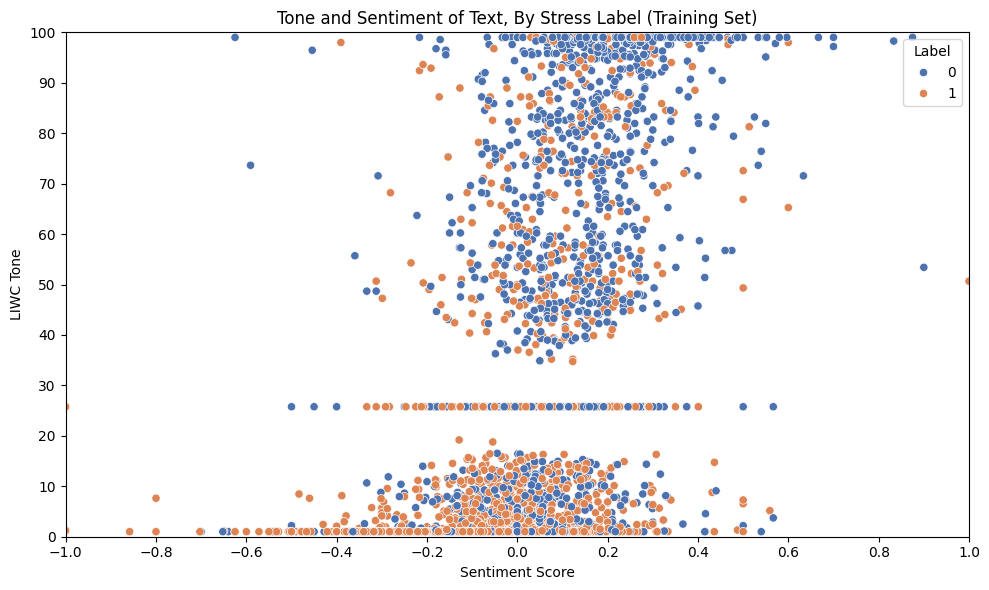

In [40]:
plot_tone_against_sentiment_by_label(train_df, "Training Set")

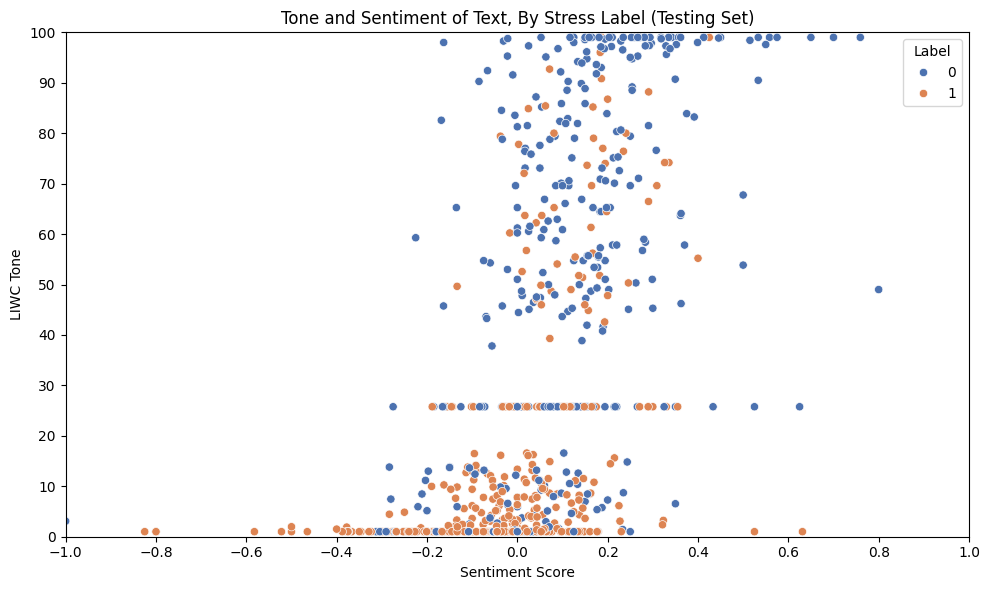

In [41]:
plot_tone_against_sentiment_by_label(test_df, "Testing Set")

The scatter plot of LIWC tone against sentiment score shows a rather clear separation, driven primarily by tone. For LIWC tone scores of 25 and below, there are substantially more "1" labels, indicating that negative emotional tone strongly aligns with stress expression (LIWC, n.d.).

Negative sentiment scores are also associated with slightly higher concentrations of stressed posts, although this separation is less pronounced than for tone. Visually, the data form two broad clusters, with the lower-tone cluster positioned slightly further to the left (ie. more negative sentiment) than the upper cluster.

Overall, tone appears to be a stronger differentiating signal than sentiment in distinguishing stressed from non-stressed posts.

To build on such visualisations, we aim to formulate a more robust approach to identifying stress in textual data - this will be done by using machine learning to leverage a wider selection of features.

## Data Processing

Here we obtain two distinct sets of features from the Dreaddit dataset - textual embeddings from a pretrained BERT encoder, as well as linguistic features from LIWC.

In subsequent steps, we wish to compare representation learning derived from a transformer encoder, with that of psychologically grounded features designed by domain experts. BERT embeddings capture rich contextual and semantic nuances in informal text, potentially identifying subtle stress signals that are not explicitly theory-driven. In comparison, LIWC features offer interpretable indicators linked to affective, cognitive, and social processes, facilitating clinical sense-making.

If transformer-based features substantially outperform LIWC, this suggests that data-driven contextual modelling captures stress signals beyond predefined linguistic categories. However, if each feature set captures complementary information, concatenating them may improve predictive performance while retaining some degree of interpretability. This idea of combining feature sets will also be explored later.

From the above rationale, we see that the chosen approach evaluates not only predictive accuracy, but also the trade-off between performance and psychological interpretability.

### Choose Columns and Rows

The attributes `social_timestamp` and `social_karma` are excluded to ensure that subsequent predictions will rely solely on textual content, rather than platform-specific metadata.

In [42]:
def drop_columns(df):
    return df.drop([
        "subreddit",
        "post_id",
        "sentence_range",
        "confidence",
        "social_timestamp",
        "social_karma"
    ], axis=1)

def remove_short_texts(df):
    df = df.copy()
    df["num_tokens"] = df["text"].str.split().str.len()
    df = df[df["num_tokens"] >= MIN_TEXT_LENGTH]
    df = df.drop(["num_tokens"], axis=1)

    return df    

In [43]:
train_df_processed = remove_short_texts(drop_columns(train_df))
test_df_processed = remove_short_texts(drop_columns(test_df))

### Create Features and Labels

We choose the case-sensitive version of BERT, because the use of capitalisation in text can potentially be an indication of the author's emotions, thereby hinting at the presence or absence of stress.

In [44]:
MODEL_NAME = "google-bert/bert-base-cased"

In [45]:
def tokenise_dataframe(df, tokeniser_name, text_column="text"):
    tokeniser = AutoTokenizer.from_pretrained(tokeniser_name)

    encodings = tokeniser(
        df[text_column].tolist(),
        padding="max_length",
        truncation=True,
        return_tensors="pt"
    )

    encodings = {k: v.to(DEVICE) for k, v in encodings.items()}
    return encodings

def get_embeddings(df, model_name, batch_size=32):
    model = AutoModelForTextEncoding.from_pretrained(model_name).to(DEVICE)

    all_embeddings = list()
    with torch.no_grad():
        for i in range(0, len(df), batch_size):
            batch_texts = df[i: i + batch_size]
            encodings = tokenise_dataframe(batch_texts, model_name)
            inputs = {k: v.to(DEVICE) for k, v in encodings.items()}
            outputs = model(**inputs)
            cls_embeddings = outputs.last_hidden_state[:, 0, :]
    
            all_embeddings.append(cls_embeddings.cpu())

            torch.cuda.empty_cache()

            print(f"Finished getting embeddings for i = {i}")
            
    embedding_features = torch.cat(all_embeddings).numpy()
    embedding_cols = [f"cls_{i}" for i in range(embedding_features.shape[1])]
    embedding_df = pd.DataFrame(embedding_features, columns=embedding_cols)

    embedding_df.insert(loc=0, column="id", value=df["id"])
    embedding_df["label"] = df["label"].values
    
    return embedding_df

In [46]:
def get_features_and_labels(df, is_for_bert_encoding):
    if is_for_bert_encoding:
        features_and_labels = get_embeddings(df, MODEL_NAME)
    
    else:
        features_and_labels = df.drop(["text"], axis=1)

    features_and_labels["label"] = features_and_labels.pop("label")
    
    return features_and_labels

In [ ]:
train_df_processed_bert = get_features_and_labels(train_df_processed, is_for_bert_encoding=True)
test_df_processed_bert = get_features_and_labels(test_df_processed, is_for_bert_encoding=True)

train_df_processed_liwc = get_features_and_labels(train_df_processed, is_for_bert_encoding=False)
test_df_processed_liwc = get_features_and_labels(test_df_processed, is_for_bert_encoding=False)

In [ ]:
train_df_processed_bert.head()

In [ ]:
test_df_processed_bert.head()

In [ ]:
train_df_processed_liwc.head()

In [ ]:
test_df_processed_liwc.head()

In [ ]:
train_df_processed_bert["label"].value_counts(normalize=True)

In [ ]:
test_df_processed_bert["label"].value_counts(normalize=True)

In [ ]:
train_df_processed_liwc["label"].value_counts(normalize=True)

In [ ]:
test_df_processed_liwc["label"].value_counts(normalize=True)

In [ ]:
# save these dataframes
DATA_PATH = os.path.normpath(os.path.join("..", "data"))
os.makedirs(DATA_PATH, exist_ok=True)

train_df_processed_bert.to_csv(os.path.join(DATA_PATH, "train_bert.csv"), index=False)
test_df_processed_bert.to_csv(os.path.join(DATA_PATH, "test_bert.csv"), index=False)
train_df_processed_liwc.to_csv(os.path.join(DATA_PATH, "train_liwc.csv"), index=False)
test_df_processed_liwc.to_csv(os.path.join(DATA_PATH, "test_liwc.csv"), index=False)

## Training Last-Stage Classifiers

Here we evaluate and compare the performance of the 3 approaches selected, where we separately train a last-stage classifier on the following sets of features: 

- BERT embeddings only
- LIWC features only
- Concatenated BERT and LIWC features

`RandomForestClassifier` was used as the `scikit-learn` classifier of choice.

In [47]:
CM_FOLDER_PATH = os.path.normpath(os.path.join(PLOTS_FOLDER_PATH, "cm"))
os.makedirs(CM_FOLDER_PATH, exist_ok=True)

MODELS_FOLDER_PATH = os.path.normpath(os.path.join("..", "models"))
os.makedirs(MODELS_FOLDER_PATH, exist_ok=True)

In [48]:
def scale_features(X_train, X_test):
    # initialise scaler
    scaler = StandardScaler()

    # fit only on training data
    X_train_scaled = scaler.fit_transform(X_train)

    # transform test data using same scaler
    X_test_scaled = scaler.transform(X_test)

    # convert back to DataFrame
    X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
    X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

    return X_train_scaled, X_test_scaled

In [49]:
def display_and_save_cm(cm: np.ndarray, filename: str) -> None:
    # make heat map of confusion matrix
    plt.figure(figsize=(8, 6))
    sns.set_theme(font_scale=0.8)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")

    # save this heat map
    cm_file_path = os.path.join(CM_FOLDER_PATH, f"{filename}_cm.png")
    plt.savefig(cm_file_path, bbox_inches="tight")

    # display heat map
    print("Confusion Matrix:")
    plt.show()


def train_and_eval_classifier(model: ClassifierMixin, X_train: np.ndarray, y_train: np.ndarray, X_test: np.ndarray, y_test: np.ndarray, filename: str) -> ClassifierMixin:
    # train the model
    model.fit(X_train, y_train)

    # predict on test set
    y_preds = model.predict(X_test)
    y_pred_probs = model.predict_proba(X_test)

    # calculate evaluation metrics
    acc = accuracy_score(y_test, y_preds)
    precision = precision_score(y_test, y_preds, pos_label=1)
    recall = recall_score(y_test, y_preds, pos_label=1)
    f1 = f1_score(y_test, y_preds, pos_label=1)
    cm = confusion_matrix(y_test, y_preds)

    # print evaluation metrics
    print(f"Accuracy: {round(acc * 100, 1)}%")
    print(f"Precision: {round(precision * 100, 1)}%")
    print(f"Recall: {round(recall * 100, 1)}%")
    print(f"F1 score: {round(f1 * 100, 1)}%")

    # display and save confusion matrix
    display_and_save_cm(cm=cm, filename=filename)
    
    # save fitted model
    with open(os.path.join(MODELS_FOLDER_PATH, f"{filename}_model.pkl"), "wb") as f:
        pickle.dump(model, f)

    return model, y_preds, y_pred_probs

### Load Data

In [50]:
train_bert = pd.read_csv(os.path.join(DATA_PATH, "train_bert.csv"))
test_bert = pd.read_csv(os.path.join(DATA_PATH, "test_bert.csv"))
train_liwc = pd.read_csv(os.path.join(DATA_PATH, "train_liwc.csv"))
test_liwc = pd.read_csv(os.path.join(DATA_PATH, "test_liwc.csv"))

In [51]:
y_train = train_bert["label"]
y_test = test_bert["label"]

X_train_bert = train_bert.drop(["id", "label"], axis=1)
X_test_bert = test_bert.drop(["id", "label"], axis=1)

X_train_liwc = train_liwc.drop(["id", "label"], axis=1)
X_test_liwc = test_liwc.drop(["id", "label"], axis=1)

X_train_concat = pd.concat([X_train_bert, X_train_liwc], axis=1)
X_test_concat = pd.concat([X_test_bert, X_test_liwc], axis=1)

### Scale Features

In [52]:
X_train_bert_scaled, X_test_bert_scaled = scale_features(X_train_bert, X_test_bert)
X_train_liwc_scaled, X_test_liwc_scaled = scale_features(X_train_liwc, X_test_liwc)
X_train_concat_scaled, X_test_concat_scaled = scale_features(X_train_concat, X_test_concat)

### BERT Embeddings

Accuracy: 70.6%
Precision: 70.9%
Recall: 73.2%
F1 score: 72.0%
Confusion Matrix:


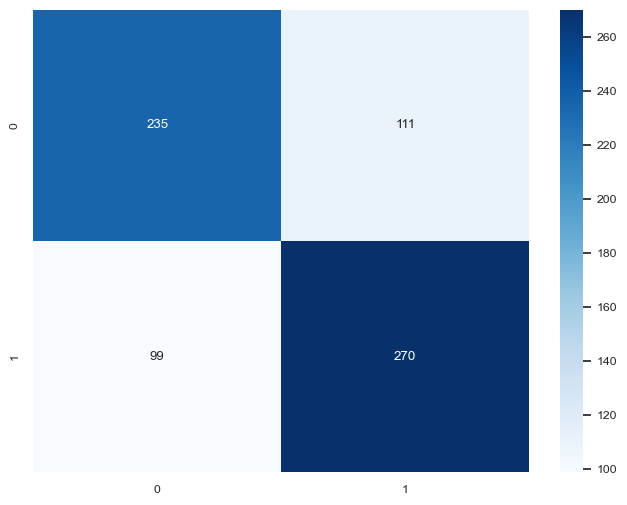

In [53]:
# initialise model
rf_bert = RandomForestClassifier(random_state=SEED)

# train and evaluate
rf_bert_fitted, rf_bert_preds, rf_bert_pred_probs = train_and_eval_classifier(model=rf_bert, X_train=X_train_bert_scaled, y_train=y_train, X_test=X_test_bert_scaled, y_test=y_test, filename="rf_bert")

### LIWC Features

Accuracy: 75.4%
Precision: 73.8%
Recall: 81.0%
F1 score: 77.3%
Confusion Matrix:


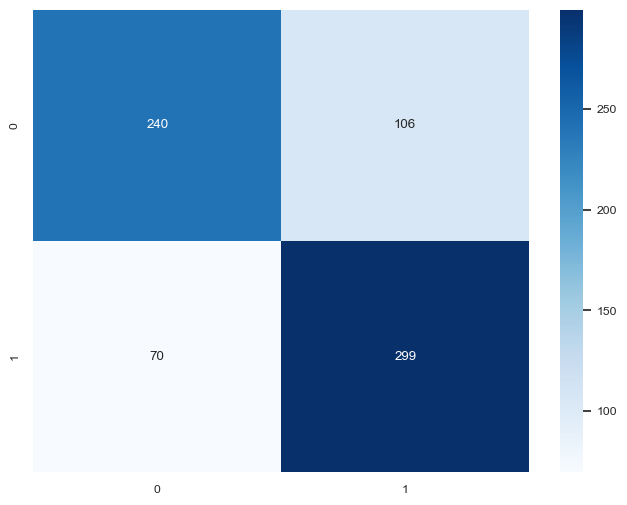

In [54]:
# initialise model
rf_liwc = RandomForestClassifier(random_state=SEED)

# train and evaluate
rf_liwc_fitted, rf_liwc_preds, rf_liwc_pred_probs = train_and_eval_classifier(model=rf_liwc, X_train=X_train_liwc_scaled, y_train=y_train, X_test=X_test_liwc_scaled, y_test=y_test, filename="rf_liwc")

### BERT + LIWC

#### Using All Features

Accuracy: 75.4%
Precision: 74.3%
Recall: 79.9%
F1 score: 77.0%
Confusion Matrix:


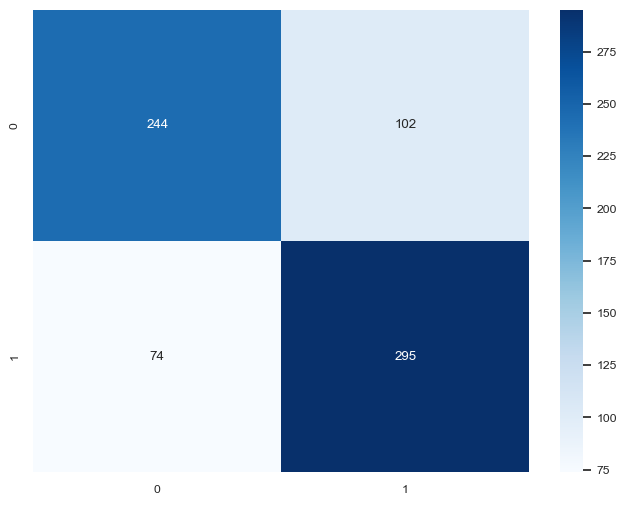

In [55]:
# initialise model
rf_concat = RandomForestClassifier(random_state=SEED)

# train and evaluate
rf_concat_fitted, rf_concat_preds, rf_concat_pred_probs = train_and_eval_classifier(model=rf_concat, X_train=X_train_concat_scaled, y_train=y_train, X_test=X_test_concat_scaled, y_test=y_test, filename="rf_concat")

The LIWC-only model outperforms the BERT-only model across all key metrics. In particular, it achieves a higher F1 score and recall. While F1 score is the primary evaluation metric for this task, recall is also crucial - especially given that our eventual goal is to deploy this workflow in an early flagging system, for mental health screening. Under such a context, the model should minimise missed cases of stress. Hence, higher recall strengthens the practical utility of the LIWC-based approach.

In addition, LIWC features are more interpretable as they effectively describe psychological elements in language, in ways that are well-understood by domain specialists. This enhances clinical sense-making and transparency, which are critical in sensitive use cases like mental health screening.

Concatenating BERT and LIWC features does not lead to a notable performance improvement over LIWC alone. However, the combined model achieves comparable results, whilst retaining the possibility that contextual embeddings capture complementary information not fully exploited in the current configuration. With further feature selection, the effectiveness of the hybrid representation may exceed that of the pure-LIWC approach. 

Evidently, the combined approach balances interpretability with expressive contextual modelling. Therefore, the concatenated feature model is selected for subsequent analysis.

#### Find Important Features (On Train Set)

Using the combined feature model, SHAP values are computed on the training set, so as to identify the most important predictors contributing to the model's decision-making process.

To determine an appropriate number of top features *k*, a list of possible hyperparameter values (10 to 200, in increments of 10) is evaluated. For each *k*, 5-fold cross-validation is conducted on the training set to prioritise performance stability. Subsequently, we choose the *k* value that corresponds to the highest F1 score.

In [56]:
explainer = shap.TreeExplainer(rf_concat)
shap_values_train = explainer.shap_values(X_train_concat_scaled)
shap_values_train_pos = shap_values_train[:, :, 1]

In [57]:
mean_shap_train = np.abs(shap_values_train_pos).mean(axis=0)
feature_importance_train = pd.DataFrame({
    "feature": X_train_concat_scaled.columns,
    "importance": mean_shap_train
}).sort_values("importance", ascending=False)

In [58]:
possible_k_values = list(range(10, 210, 10))
cv_f1_scores = list()

# loop through possible top k values and perform CV on training data
for num_impt_features in possible_k_values:
    print(f"Try k = {num_impt_features}")
    
    top_k = feature_importance_train["feature"].head(num_impt_features)

    rf = RandomForestClassifier(random_state=SEED)

    score = cross_val_score(
        rf,
        X_train_concat_scaled[top_k],
        y_train,
        cv=5,
        scoring="f1"
    ).mean()

    cv_f1_scores.append(score)

k_and_f1_scores = list(zip(possible_k_values, cv_f1_scores))
k_and_f1_scores.sort(key=lambda pair: pair[1], reverse=True)

Try k = 10
Try k = 20
Try k = 30
Try k = 40
Try k = 50
Try k = 60
Try k = 70
Try k = 80
Try k = 90
Try k = 100
Try k = 110
Try k = 120
Try k = 130
Try k = 140
Try k = 150
Try k = 160
Try k = 170
Try k = 180
Try k = 190
Try k = 200


In [59]:
k_and_f1_scores[0]

(70, np.float64(0.7898183039339728))

Hence, we choose *k* = 70.

In [60]:
# get the most important feature names
chosen_num_impt_features = k_and_f1_scores[0][0]
top_feature_importance_train = feature_importance_train.head(chosen_num_impt_features)
important_features = list(top_feature_importance_train["feature"])

In [61]:
important_features

['lex_liwc_negemo',
 'lex_liwc_Tone',
 'lex_liwc_i',
 'sentiment',
 'lex_liwc_Clout',
 'lex_liwc_anx',
 'lex_dal_min_pleasantness',
 'lex_liwc_social',
 'lex_liwc_Authentic',
 'cls_193',
 'cls_490',
 'lex_liwc_anger',
 'cls_545',
 'lex_liwc_focuspresent',
 'cls_97',
 'cls_611',
 'cls_331',
 'cls_622',
 'cls_465',
 'cls_365',
 'cls_748',
 'cls_114',
 'lex_liwc_posemo',
 'cls_609',
 'cls_292',
 'cls_564',
 'cls_598',
 'lex_liwc_Dic',
 'cls_59',
 'cls_210',
 'cls_689',
 'cls_396',
 'cls_280',
 'cls_291',
 'cls_198',
 'cls_705',
 'cls_543',
 'lex_liwc_feel',
 'cls_194',
 'cls_196',
 'lex_liwc_sad',
 'cls_271',
 'cls_99',
 'cls_550',
 'cls_131',
 'cls_738',
 'cls_441',
 'cls_176',
 'cls_160',
 'cls_164',
 'cls_455',
 'cls_743',
 'cls_354',
 'cls_154',
 'cls_30',
 'cls_428',
 'cls_214',
 'cls_621',
 'cls_487',
 'cls_497',
 'cls_185',
 'cls_21',
 'cls_605',
 'cls_386',
 'cls_636',
 'lex_liwc_adverb',
 'cls_413',
 'cls_707',
 'cls_71',
 'cls_477']

### Select Important Features

For dimensionality reduction, we select the 70 most important features from the concatenated feature set. We then train a new `RandomForestClassifier` on the resultant set of training set of features, before evaluating its performance on the testing set.

In [62]:
X_train_concat_impt_features_scaled = X_train_concat_scaled[important_features]
X_test_concat_impt_features_scaled = X_test_concat_scaled[important_features]

In [63]:
X_train_concat_impt_features_scaled.shape

(2834, 70)

In [64]:
X_test_concat_impt_features_scaled.shape

(715, 70)

Accuracy: 76.1%
Precision: 74.6%
Recall: 81.3%
F1 score: 77.8%
Confusion Matrix:


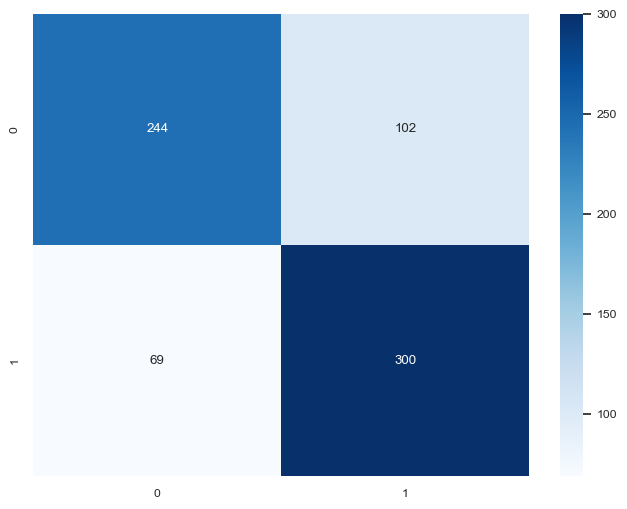

In [65]:
# initialise model
rf_concat_impt_features = RandomForestClassifier(random_state=SEED)

# train and evaluate
rf_concat_impt_features_fitted, rf_concat_impt_features_preds, rf_concat_impt_features_pred_probs = train_and_eval_classifier(model=rf_concat_impt_features, X_train=X_train_concat_impt_features_scaled, y_train=y_train, X_test=X_test_concat_impt_features_scaled, y_test=y_test, filename="rf_concat_impt_features")

Both recall and F1 score show small improvements from the previous combined model, and the F1-score is slightly higher than the LIWC-only model. The improvement in recall further strengthens the model’s suitability for stress flagging, where minimising missed cases is critical.

Moreover, reducing the feature space lowers model complexity and helps mitigate the risk of overfitting, allowing for more effective generalisation to unseen data.

## Explainability of Final Approach: SHAP Values

To interpret the classification process of the final model, we now determine SHAP values on the testing set.

In [66]:
explainer = shap.TreeExplainer(rf_concat_impt_features)
shap_values_test = explainer.shap_values(X_test_concat_impt_features_scaled)
shap_values_test_pos = shap_values_test[:, :, 1]

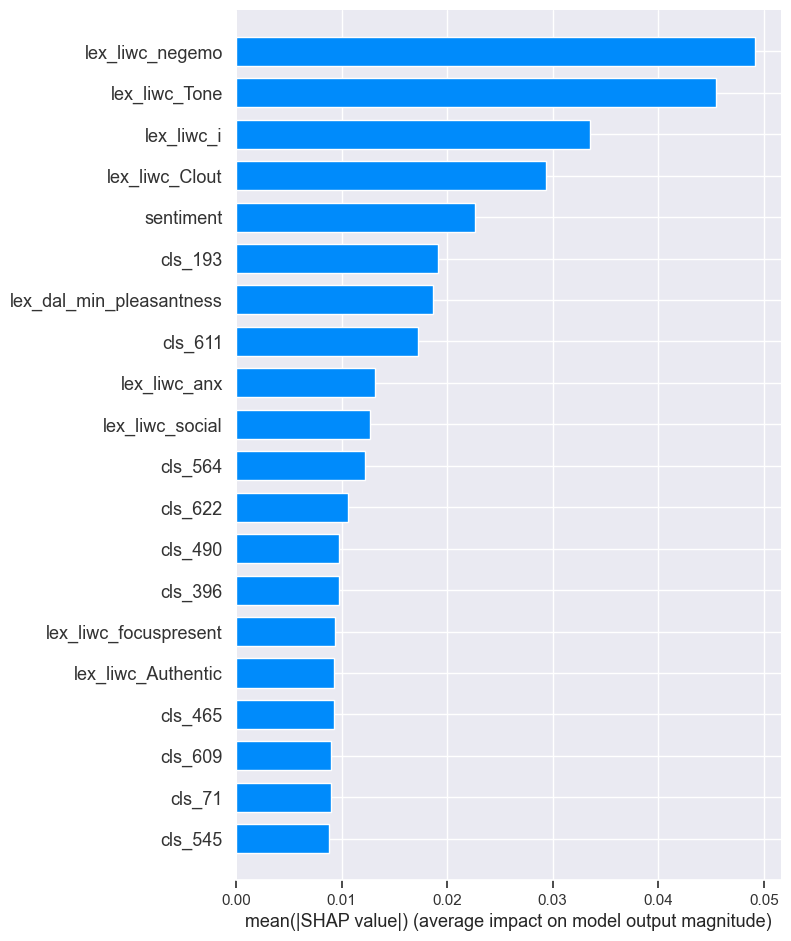

In [67]:
shap.summary_plot(
    shap_values_test_pos,
    X_test_concat_impt_features_scaled,
    plot_type="bar"
)

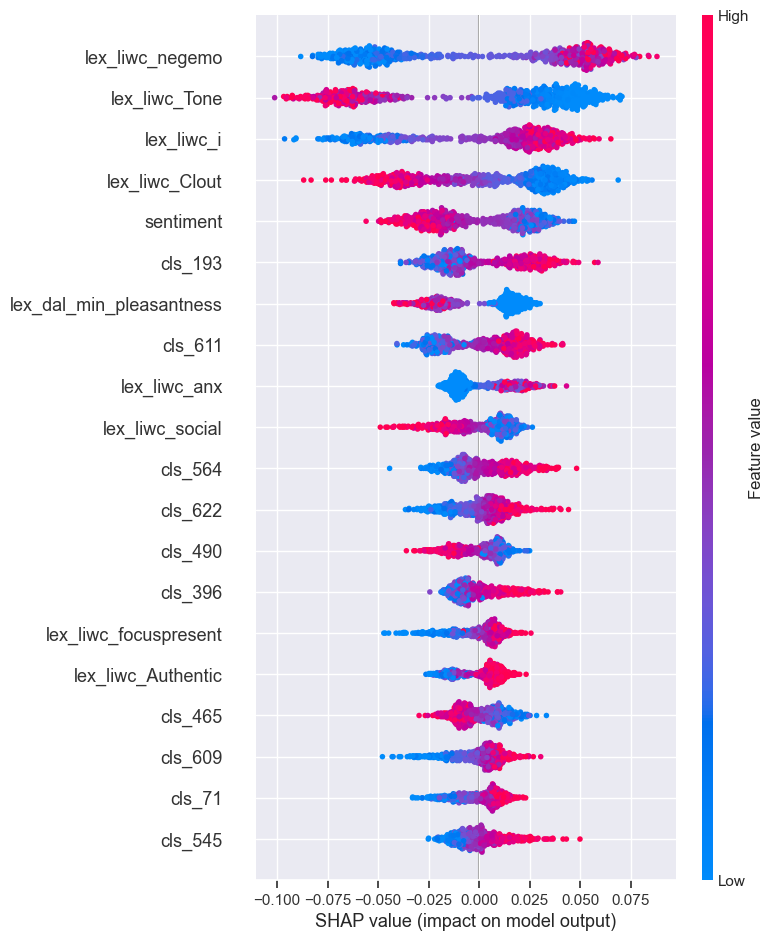

In [68]:
shap.summary_plot(
    shap_values_test_pos,
    X_test_concat_impt_features_scaled
)

From the summary plots, the top five most important features are predominantly LIWC-based:

- **lex_liwc_negemo**: Higher values increase the probability of predicting stress.
- **lex_liwc_Tone**: Lower values increase the probability of predicting stress.
- **lex_liwc_i**: Higher values increase the probability of predicting stress.
- **lex_liwc_Clout**: Lower values increase the probability of predicting stress.
- **sentiment**: More negative values increase the probability of predicting stress.

These observations can be explained reasonably. Greater use of negative emotion words, more negative sentiment, and more negative emotional tone are directly associated with expressions of distress. Increased first-person singular pronoun use ("I") is commonly associated with self-focused attention, which has been linked to stress and rumination (Brockmeyer et al., 2015). Lower clout scores suggest reduced confidence or social dominance, which may reflect vulnerability under stressful circumstances (Pennebaker et al., 2015).

Although some contextual embedding features are considered to be important as well (eg. `cls_193`, the 6th most important feature), the top 10 features are largely LIWC-derived. This reinforces the earlier finding that psychologically grounded linguistic markers play a dominant role in stress prediction within this dataset.

## Error Analysis

We proceed to analyse the misclassifications of our workflow.

In [69]:
ERROR_ANALYSIS_PATH = os.path.normpath(os.path.join(PLOTS_FOLDER_PATH, "error_analysis"))
os.makedirs(ERROR_ANALYSIS_PATH, exist_ok=True)

In [70]:
ids = test_bert["id"]

pred_confidences = [probs[pred_class] for probs, pred_class in zip(rf_concat_impt_features_pred_probs, rf_concat_impt_features_preds)]

ids_and_preds_df = pd.DataFrame({
    "id": ids,
    "pred": rf_concat_impt_features_preds,
    "pred_confidence": pred_confidences
})

error_analysis_df = pd.merge(test_df, ids_and_preds_df, on="id")
error_analysis_df = error_analysis_df[[
    "id",
    "subreddit",
    "text",
    "pred",
    "pred_confidence",
    "label",
    "confidence"
]]
error_analysis_df["pred_correctness"] = error_analysis_df["pred"] == error_analysis_df["label"]

In [71]:
error_analysis_df.head()

,id,subreddit,text,pred,pred_confidence,label,confidence,pred_correctness
0,896,relationships,"Its like that, if you want or not.“ ME: I have...",0,0.67,0,0.8,True
1,19059,anxiety,I man the front desk and my title is HR Custom...,0,0.54,0,1.0,True
2,7977,ptsd,We'd be saving so much money with this new hou...,1,0.56,1,1.0,True
3,1214,ptsd,"My ex used to shoot back with ""Do you want me ...",1,0.57,1,0.5,True
4,1965,relationships,I haven’t said anything to him yet because I’m...,1,0.58,0,0.8,False


### Performance by Subreddit

In [72]:
metrics_by_subreddit_list = list()

for sub, group in error_analysis_df.groupby("subreddit"):
    y_true = group["label"]
    y_pred = group["pred"]
    
    metrics_by_subreddit_list.append({
        "subreddit": sub,
        "recall": recall_score(y_true, y_pred, zero_division=0),
        "f1": f1_score(y_true, y_pred, zero_division=0)
    })

metrics_by_subreddit_df = pd.DataFrame(metrics_by_subreddit_list)
metrics_by_subreddit_df = metrics_by_subreddit_df.sort_values("f1", ascending=False)

In [73]:
metrics_by_subreddit_df.head()

,subreddit,recall,f1
6,ptsd,0.902439,0.870588
3,domesticviolence,0.893617,0.857143
8,stress,0.800000,0.842105
1,anxiety,0.929412,0.814433
4,food_pantry,0.666667,0.800000


In [75]:
# pivot longer
metrics_by_subreddit_pivot_longer_df = metrics_by_subreddit_df.melt(
    id_vars="subreddit",
    value_vars=["recall", "f1"],
    var_name="metric",
    value_name="score"
)

metrics_by_subreddit_pivot_longer_df.head()

,subreddit,metric,score
0,ptsd,recall,0.902439
1,domesticviolence,recall,0.893617
2,stress,recall,0.800000
3,anxiety,recall,0.929412
4,food_pantry,recall,0.666667


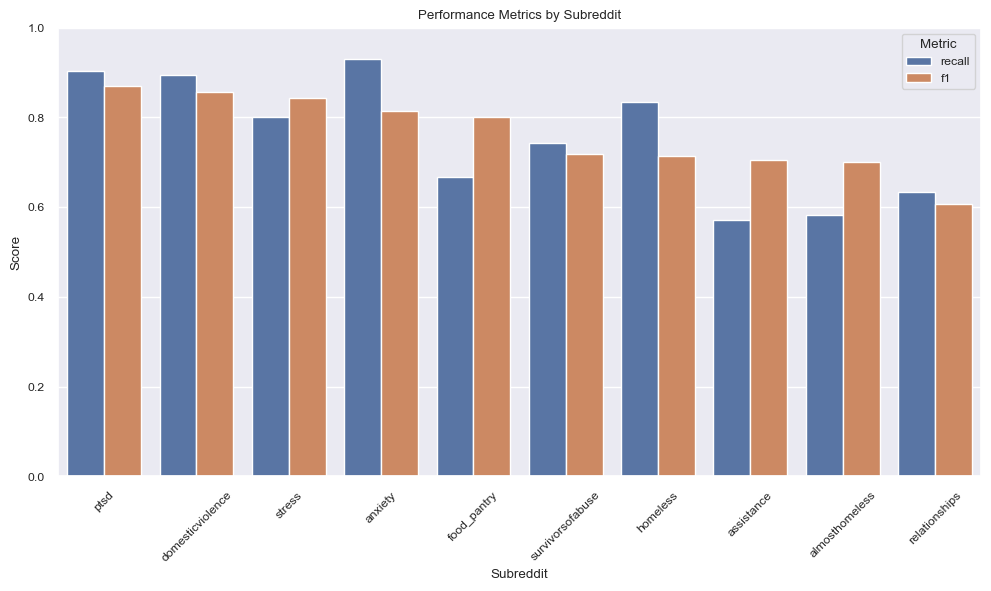

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))

# grouped bar chart
sns.barplot(
    data=metrics_by_subreddit_pivot_longer_df,
    x="subreddit",
    y="score",
    hue="metric"
)

# set title, axes and legend
plt.title(f"Performance Metrics by Subreddit")
ax.set_xlabel("Subreddit")
ax.set_ylabel("Score")
ax.legend(title="Metric")

# edit x axis
plt.xticks(rotation=45)

# edit y axis
ax.set_ylim(0, 1)

plt.tight_layout()

# save plot
plt.savefig(os.path.join(ERROR_ANALYSIS_PATH, f"performance_by_subreddit.png"))

plt.show()

The following insights can be drawn:

**r/relationships** corresponds to the lowest F1 score, indicating that stress is more difficult to detect in this subreddit. This may be due to the mixed nature of posts, which often include advice, reflections on interpersonal issues, or neutral discussions rather than direct expressions of stress. Consequently, the linguistic markers of stress (eg. from LIWC) are less consistent, reducing the model’s predictive power.

**r/assistance** exhibits the lowest recall, suggesting that a notable proportion of stressed posts is missed. There are more posts in this subreddit that take a practical, informational, or motivational tone, which may overshadow explicit stress signals in language. Hence, these posts may be classified as "not stressed" by the model, even if they actually are. This highlights the challenge of detecting stress in communities that focus on guidance and support, as opposed to personal disclosure.

In contrast, **r/ptsd** achieves the highest F1 score. Posts in this subreddit tend to contain clearer and more consistent stress-related language, reflecting traumatic experiences and emotional struggles. The strong signal in linguistic markers allows the model to classify posts more effectively.

**r/anxiety** demonstrates the highest recall, which can be explained by the predominance of stressed posts in this community. Since most posts carry a positive ("stressed") label, it is easier for the model to correctly identify stressed posts, boosting recall even if other metrics like precision are moderate.

As a result, classification performance is strongly influenced by subreddit context, post style, and label distribution.

### Label and Prediction Confidences

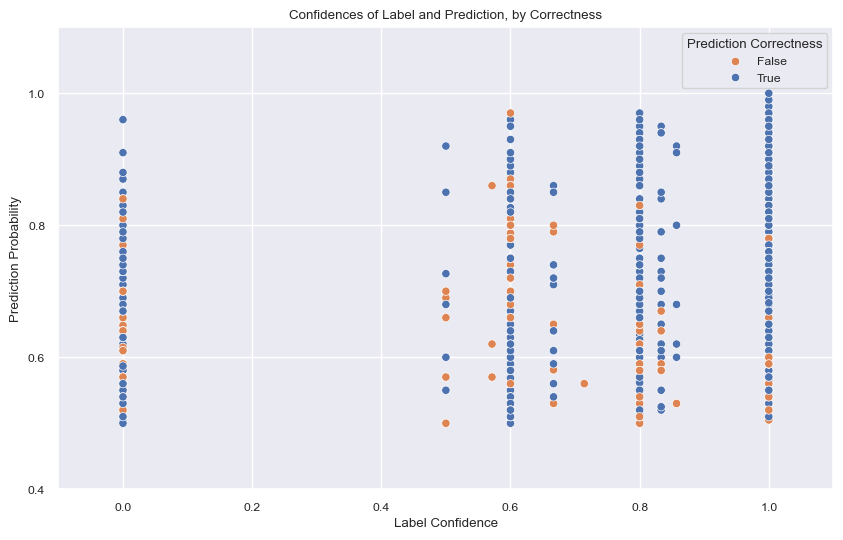

In [77]:
fig, ax = plt.subplots(figsize=(10, 6))

# scatter plot by label
sns.scatterplot(
    data=error_analysis_df,
    x="confidence",
    y="pred_confidence",
    hue="pred_correctness",
    palette={0: "#DD8452", 1: "#4C72B0"}
)

# set title, axes and legend
plt.title(f"Confidences of Label and Prediction, by Correctness")
ax.set_xlabel("Label Confidence")
ax.set_ylabel("Prediction Probability")
ax.legend(title="Prediction Correctness")

# edit x axis
ax.set_xlim(-0.1, 1.1)
ax.xaxis.set_major_locator(mticker.MultipleLocator(0.2))

# edit y axis
ax.set_ylim(0.4, 1.1)
ax.yaxis.set_major_locator(mticker.MultipleLocator(0.2))

# save plot
plt.savefig(os.path.join(ERROR_ANALYSIS_PATH, f"confidence_scatter_plot.png"))

plt.show()

We observe that as prediction probability (w.r.t the predicted class) decreases, the frequency of incorrect predictions increases. This is expected, as lower confidence in the model's predictions indicates that it is more uncertain, making it more prone to misclassifications.

In contrast, predictions with both high probability and high label confidence rarely result in errors. However, errors do still occur in this region. In fact, these instances are particularly important, as they represent cases where the model is confidently wrong. Investigating such errors can reveal subtle patterns or limitations in the model’s understanding of stress signals.

Errors in regions with low label confidence are more understandable, since the ground truth may be inherently ambiguous or subjective. Similarly, when prediction confidence is low, the model’s uncertainty aligns with a higher likelihood of mistakes.

### Finding Confident but Wrong Predictions

In [78]:
# we want test samples that have a high label confidence, high prediction probability
# but incorrect prediction
MIN_LABEL_CONFIDENCE = 0.8
MIN_PRED_CONFIDENCE = 0.8

In [79]:
error_analysis_df_confident_mistakes = error_analysis_df[
    (error_analysis_df["confidence"] >= MIN_LABEL_CONFIDENCE)
    & (error_analysis_df["pred_confidence"] >= MIN_PRED_CONFIDENCE)
    & (~error_analysis_df["pred_correctness"])
]

In [80]:
error_analysis_df_confident_mistakes

,id,subreddit,text,pred,pred_confidence,label,confidence,pred_correctness
85,29364,ptsd,I just wanted to say thank you to everyone tha...,1,0.81,0,1.0,False
634,5899,anxiety,"I needed to run some errands, but it was a Sat...",1,0.81,0,0.8,False
651,739,survivorsofabuse,"When I was 17, my mom turned her attacks on my...",1,0.83,0,0.8,False


In [82]:
for _, row in error_analysis_df_confident_mistakes.iterrows():
    text, pred, label = row["text"], row["pred"], row["label"]
    print(f"Prediction: {pred} | Label: {label}")
    print("Text:")
    print(text)
    print()

Prediction: 1 | Label: 0
Text:
I just wanted to say thank you to everyone that posts on here. I just found this subreddit yesterday and reading all of your guys' posts have made me feel so much less alone. Knowing that other people understand what I'm going through for some reason has helped me tremendously. Particularly a post that someone made about feeling like their trauma isnt real and like convincing yourself that it didnt happen. I have felt like I'm crazy for years because I was in such deep denial about what happened to me.

Prediction: 1 | Label: 0
Text:
I needed to run some errands, but it was a Saturday afternoon when stores were usually too busy for me, but I felt so great I decided to try it. I went into a busy store and actually waited in line to pay infont of a very obnoxious couple who didn't understAnd personal space. I was totally fine. I couldn't believe it. In other situations i'd have to avoid the store all together or walk around the store until the line went dow

Upon inspection of these 3 errors, we glean the following insights:

**Text 1**: Although the overall tone of the post is appreciative, the final sentences reference trauma and prolonged emotional struggle ("I have felt like I'm crazy for years…"). These expressions may strongly activate features such as negative emotion, low tone, and first-person focus - all of which are important features from the SHAP analysis. The discussion of another user’s invalidated trauma - as well as the writer’s own long-term distress - likely signals stress linguistically, even if the post itself is framed positively.

**Text 2**: There is a frequent usage of first-person singular pronouns ("I"), which are associated with self-focus. The latter half of the text includes emotionally charged phrases such as "avoid", "dizzy", and "freaking out". Although these experiences are described as occurring in "other situations", the model does not capture this contextual distinction. Instead, the presence of negative emotional language and lower tone likely increases the predicted stress probability - consistent with the SHAP findings.

**Text 3**: The text includes multiple words with strong, negative connotations ("berated", "pointless", "worthless", etc.). These describe emotionally harmful experiences involving the writer’s mother. From a linguistic perspective, these markers may be likened to stress-related elements, making it understandable that the model predicts the positive class.

From this, we see a limitation of the current approach. The model is sensitive to negative emotional language, even when such language is embedded in narrative or past-tense contexts that may not constitute current stress. This can be attributed to the workflow's usage of LIWC measures, which are features at the word-level only. Hence, our approach may fail to capture semantic nuances in broader contexts, leading to more false positives.

From the above error analysis, we have the following takeaways:

- **Performance depends on community context.** Model performance varies across subreddits, suggesting that stress expression is shaped by forum norms and post style.
- **Psychologically grounded features are integral.** LIWC features dominate the most important predictors, supporting their value for stress detection and interpretability, though contextual features may still add complementary information.
- **Word-level features have limitations.** LIWC operates largely at the word-level and may miss broader semantic context, leading to false positives when negative language does not reflect current stress.

## Deployment

This solution can be adapted for deployment within an NUS-specific online forum, similar in nature to r/nus, where students share experiences and concerns. Posts or comments can be automatically screened for stress signals. When flagged, users may receive supportive resources, such as stress management tips. They can also be offered the option to speak with other users, so as to seek respite from their problems.

Informed by the aforementioned takeaways, such a model should be trained on text drawn from a similar contextual environment (eg. r/nus posts and comments). As performance varies across communities, using domain-specific training data helps ensure that the linguistic patterns of stress - unique to NUS students - are captured by our workflow.

Consistent with the SHAP analysis, LIWC features will form a core component of prediction due to their psychological grounding and interpretability. However, recognising the limitations of word-level features, contextual embeddings will also be incorporated. Rather than relying solely on a pre-trained encoder (as we have done in our investigation), BERT can be further fine-tuned on an NUS-specific corpus (eg. r/nus) for stress classification. This allows the resultant textual embeddings to be more representative of not only the NUS context, but also the downstream task of stress recognition.

By concatenating LIWC measures with fine-tuned contextual embeddings, we directly addresses earlier limitations, whilst preserving interpretability and adaptability to the chosen target audience of NUS students.

## Limitations and Risks

First and foremost, the absence of annotations and labels in the r/nus corpus presents a practical challenge. Substantial time and labour are required to review such training data. Collaboration with domain experts is necessary for not only stress labelling, but also the determination of LIWC features.

Moreover, although BERT embeddings make the prediction process more robust, they lack inherent interpretability. Additional tools, such as attention maps, are necessary to improve transparency.

Furthermore, our preliminary investigation focuses solely on the `RandomForestClassifier`. Exploring alternative classifiers may allow us to attain performance improvements.

Ethical considerations should also be kept in mind. Mental health data is highly sensitive - both textual inputs and derived stress indicators must be handled with strict privacy safeguards to ensure that user identities cannot be traced or exposed.

The risk of false negatives is particularly concerning as well. In a mental health setting, failing to flag genuinely stressed individuals may delay crucial access to support - this may lead to deterioration of the person's mental welfare. Deployment should therefore prioritise high recall, so as to reduce the likelihood of missed intervention opportunities.

On this note, it is therefore imperative that humans remain in the loop for this deployed solution. Psychologists should be able to review model outputs, verifying that its decision-making process is reasonable. Not only does this uphold transparency, it would also allow specialists to identify particularly severe cases, amongst those users who have been flagged. With this added nuance, our proposal can go beyond binary labels,  allowing more targeted action to be taken for those who need greater assistance.

## References

- LIWC. (n.d.). *LIWC Analysis.* LIWC. https://www.liwc.app/help/liwc
- Brockmeyer, T., Zimmermann, J., Kulessa, D., Hautzinger, M., Bents, H., Friederich, H., Herzog, W., & Backenstrass, M. (2015). Me, myself, and I: Self-referent word use as an indicator of self-focused attention in relation to depression and anxiety. *Frontiers in Psychology, 6*, 1564. https://doi.org/10.3389/fpsyg.2015.01564
- Pennebaker, J. W., Booth, R. J., Boyd, R. L., & Francis, M. E. (2015). *Linguistic inquiry and word count: LIWC2015.* LIWC. https://liwc.app/static/documents/LIWC2015%20Manual%20-%20Operation.pdf